In [1]:
#pip install scikit-learn
#pip install pandas

# Main imports pandas and sklearn
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics

# imports for vectorization
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import HashingVectorizer
import gensim
from gensim.parsing.preprocessing import remove_stopwords
from gensim.models import Word2Vec

from sklearn import svm
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from gensim.models import word2vec

# We may need to do some web scraping to get the review text
import urllib.request
from bs4 import BeautifulSoup

#Other imports
import numpy as np
import time
import sys
from os import system
from IPython.display import clear_output

# Load in data
### There are a few steps to getting clean data
- Read data from kaggle into dataframes
- Get rid of unecessary features of the data
- (For game spot data) get the review text from the web
- Clean data using dropna

## Read in data from csv

In [2]:
# download dataset at: https://www.kaggle.com/datasets/joyshil0599/multi-decade-video-game-review-dataset
GAME_SPOT_DATASET_PATH = "data/game_spot_data.csv"
# downoad dataset at: https://www.kaggle.com/datasets/andrewmvd/steam-reviews
STEAM_DATASET_PATH = 'data/steam_data.csv'
# download dataset at: https://www.kaggle.com/datasets/noahx1/elden-ring-steam-reviews
ELDEN_RING_DATASET_PATH = "data/elden_ring_data.csv"

# Read in the datasets
game_spot_data = pd.read_csv(GAME_SPOT_DATASET_PATH)
steam_data = pd.read_csv(STEAM_DATASET_PATH)
elden_ring_data = pd.read_csv(ELDEN_RING_DATASET_PATH)

In [3]:
# Lets only keep the columns we want
game_spot_cols = ['Review link','Rating/10']
if('Review' in game_spot_data.columns):
    game_spot_cols.append('Review')
steam_cols = ['review_text','review_score']
elden_ring_cols = ['voted_up','review']

game_spot_data = game_spot_data[game_spot_cols]
steam_data = steam_data[steam_cols]
elden_ring_data = elden_ring_data[elden_ring_cols]

# Lets rename some columns and change them to be consistant
steam_data['review_score'].replace({1:True,-1:False},inplace=True)
steam_data.rename(columns={'review_score':'up_vote','review_text':'Review'}, inplace=True)
elden_ring_data.rename(columns={'voted_up':'up_vote','review':'Review'},inplace=True)

In [4]:
#steam data too large, lets drop some stuff
steam_data = steam_data.sample(frac=0.1)

# Read in reviews from web (for game spot data)

In [5]:
# Now lets define how to get the text of the reviews from the web
def GetReviewsFromWeb():
    num_processed = 1
    prev_time = time.time()
    num_links = len(game_spot_data.index)
    check_interval = 5
    reviews = []
    failed_links = []
    for link in game_spot_data['Review link']:
        # Try to get the review text
        try:
            page = urllib.request.urlopen(link).read()
            page = BeautifulSoup(page)
            review = ""
            body = page.find(class_="article-body typography-format")
            paragraphs = body.find_all("p")
            if(len(paragraphs)==0):
                raise Exception('NO REVIEW TEXT FOUND')
            for p in paragraphs:
                review+=p.text+" "
            reviews.append(review)
        # If we could not get the review text
        except:
            reviews.append(None)
            failed_links.append(link)
        # Display progress
        num_processed = num_processed + 1
        if(num_processed % check_interval == 0):
            prediction = (time.time() - prev_time)/(check_interval) * (num_links-len(reviews))
            prev_time = time.time()
            system('cls')
            clear_output(wait=True)
            print(f"Reviews lost: {len(failed_links)}")
            print(f"processed: {num_processed} / {num_links}")
            print(f"Time left: {int(prediction)} s")  
    # Update dataframe and write to file
    game_spot_data['Review'] = reviews
    

In [6]:
# If gamespot data does not have review then we need to get it from the web
if(not 'Review' in game_spot_data.columns):
    GetReviewsFromWeb()
    game_spot_data.to_csv(GAME_SPOT_DATASET_PATH, index=False)

# Now lets define our classifications (Sentiment)

In [7]:
# We define 2 sentiments to classify
GOOD = 'Good'
BAD = 'Bad'

In [8]:
def GetSentimentFromRating(rating):
    if(rating is None):
        return None
    if(rating > 7):
        return GOOD
    if(rating > 0):
        return BAD

In [9]:
def GetSentimentFromUpVote(up_vote):
    if(up_vote):
        return GOOD
    else:
        return BAD

In [10]:
def AddSentiment(df):
    s = []
    if('Rating/10' in df.columns):
        for rating in game_spot_data['Rating/10'].to_list():
            s.append(GetSentimentFromRating(rating))
    elif('up_vote' in df.columns):
        for upvote in df['up_vote'].to_list():
            s.append(GetSentimentFromUpVote(upvote))
    else:
        raise Exception(f"No column in dataframe to use for sentiment! {df.columns}")
    df['Sentiment'] = s
    print("DATA DISTRIBUTION:")
    SENTIMENTS = df['Sentiment'].unique()
    for s in SENTIMENTS:
        print(f"{s}: {sum(1 for i in df['Sentiment'] if i == s)}")

In [11]:
AddSentiment(game_spot_data)
AddSentiment(steam_data)
AddSentiment(elden_ring_data)

DATA DISTRIBUTION:
Bad: 6743
Good: 5823
DATA DISTRIBUTION:
Bad: 115595
Good: 526116
DATA DISTRIBUTION:
Good: 9201
Bad: 593


# Clean data

In [12]:
def CleanData(df):
    # Now lets finish cleaning the data by dropping any invalid rows
    old_size = df.shape
    df.dropna(inplace=True)
    new_size = df.shape
    print("Dropping rows")
    print(f"Old count: {old_size[0]}")
    print(f"New count: {new_size[0]}")
    print(f"Removed {old_size[0]-new_size[0]} rows.")
    

In [13]:
CleanData(game_spot_data)
CleanData(steam_data)
CleanData(elden_ring_data)

Dropping rows
Old count: 12566
New count: 12566
Removed 0 rows.
Dropping rows
Old count: 641711
New count: 640955
Removed 756 rows.
Dropping rows
Old count: 9794
New count: 9765
Removed 29 rows.


# Now we split our data

In [14]:
def SplitData(df,test_split=0.3):
    #split datasets
    X = df['Review']
    y = df['Sentiment'] 
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_split, random_state=1) 
    X_train = X_train.to_list()
    X_test = X_test.to_list()
    y_train = y_train.to_list()
    y_test = y_test.to_list()
    return X_train, X_test, y_train, y_test 

In [15]:
game_spot_X_train, game_spot_X_test, game_spot_y_train, game_spot_y_test = SplitData(game_spot_data)
steam_X_train, steam_X_test, steam_y_train, steam_y_test = SplitData(steam_data)
elden_ring_X_train, elden_ring_X_test, elden_ring_y_train, elden_ring_y_test = SplitData(elden_ring_data)

## Vectorize the data
We will be using four methods:
- **Term Frequency and Inverse Document Frequency (TF-IDF)**. https://medium.com/@vasista/preparing-the-text-data-with-scikit-learn-b31a3df567e
- Count
- Hash
- Word2Vec (not in sklearn)
#### sklearn supplies an easy way to implement most of these, but we need to define word2vec

In [16]:
class W2V_Vectorizer:
    def __init__(self):
        self.vec_size = 300
        self.vectorizer = Word2Vec(vector_size=self.vec_size,workers=256)
    def tokenize(self, data):
        review_tokens = []
        for i, review in enumerate(data):
            tokens = []
            for word in review.split(' '):
                word = word.split('.')[0]
                word = word.lower()
                tokens.append(word)
            review_tokens.append(tokens)
        return review_tokens
    def transform(self, data):
        #print("vectorizing...")
        review_tokens = self.tokenize(data)
        vectors = []
        for review in review_tokens:
            vec = np.zeros(self.vec_size).reshape((1, self.vec_size))
            count = 0
            for token in review:
                try:
                    vec += self.vectorizer.wv[token].reshape((1, self.vec_size))
                    count += 1
                except KeyError:
                    continue
            vectors.append(vec[0])
        #print("done vectorizing.")
        return vectors
    def fit_transform(self, X_train):
        print("fitting W2V transform...")
        print("Tokenizing...")
        tokenized_review = []
        tokenized_sentences = []
        for i, review in enumerate(X_train):
            for sentence in review.split('.'):
                tokenized_sentence = self.tokenize([sentence])[0]
                tokenized_review.append(tokenized_sentence)
                tokenized_sentences.append(tokenized_sentence)
        print("done Tokenizing")
        print("building vocab...")
        self.vectorizer.build_vocab(tokenized_sentences) 
        print("done building vocab.")
        print("training W2V...")
        self.vectorizer.train(tokenized_sentences, total_examples=len(tokenized_sentences), epochs=10)
        print("done training W2V.")
        train_vectors = self.transform(X_train)
        print("done fitting W2V transform.")
        return train_vectors

In [17]:
def CreateVectorizerCount(X_train):
    vectorizer = CountVectorizer()
    train_vectors = vectorizer.fit_transform(X_train)
    return vectorizer, train_vectors
def CreateVectorizerTFID(X_train):
    vectorizer = TfidfVectorizer(min_df = 5,max_df = 0.8,sublinear_tf = True,use_idf = True)
    train_vectors = vectorizer.fit_transform(X_train)
    #print(train_vectors)
    return vectorizer, train_vectors
def CreateVectorizerHashing(X_train):
    vectorizer = HashingVectorizer()
    train_vectors = vectorizer.fit_transform(X_train)
    return vectorizer, train_vectors
def CreateVectorizerWord2Vec(X_train):            
    vectorizer = W2V_Vectorizer()
    train_vectors = vectorizer.fit_transform(X_train)
    return vectorizer, train_vectors

# Creating svm
#### Helpful link to understand how this works:
- https://medium.com/@vasista/sentiment-analysis-using-svm-338d418e3ff1



In [18]:
def TestSVM(svm_linear, vectorizer, X_test, y_test, title=""): 
    print('Testing SVM ...')
    start_time = time.time()
    test_vectors = vectorizer.transform(X_test)
    prediction = svm_linear.predict(test_vectors)
    end_time = time.time()
    print(f"Tested SVM in {end_time-start_time} s")
    report = classification_report(y_test, prediction, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, prediction)
    cm_disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels = svm_linear.classes_)
    cm_disp.plot()
    key = 'accuracy'
    cm_disp.ax_.set_title(f'{title}\n{key}: {report[key]}\n')
    print(f'{key}: {report[key]}\n')
    return report

In [19]:
def CreateSVMCount(x_train, y_train):
    print('training SVM...')
    start_time = time.time()
    vectorizer, train_vectors = CreateVectorizerCount(x_train)
    svm_linear = svm.LinearSVC()
    svm_linear.fit(train_vectors, y_train)
    end_time = time.time()
    print(f"Trained SVM in {end_time-start_time} s")
    return svm_linear, vectorizer
def CreateSVMTFID(x_train, y_train):
    print('training SVM...')
    start_time = time.time()
    vectorizer, train_vectors = CreateVectorizerTFID(x_train)
    svm_linear = svm.LinearSVC()
    svm_linear.fit(train_vectors, y_train)
    end_time = time.time()
    print(f"Trained SVM in {end_time-start_time} s")
    return svm_linear, vectorizer
def CreateSVMHashing(x_train, y_train):
    print('training SVM...')
    start_time = time.time()
    vectorizer, train_vectors = CreateVectorizerHashing(x_train)
    svm_linear = svm.LinearSVC(max_iter=10000)
    svm_linear.fit(train_vectors, y_train)
    end_time = time.time()
    print(f"Trained SVM in {end_time-start_time} s")
    return svm_linear, vectorizer
def CreateSVMWord2Vec(x_train, y_train):
    print('training SVM...')
    start_time = time.time()
    vectorizer, train_vectors = CreateVectorizerWord2Vec(x_train)
    svm_linear = svm.LinearSVC()
    svm_linear.fit(train_vectors, y_train)
    end_time = time.time()
    print(f"Trained SVM in {end_time-start_time} s")
    return svm_linear, vectorizer


# Train SVM with game spot data

In [20]:
game_spot_svm_Count, game_spot_vectorizer_Count = CreateSVMCount(game_spot_X_train, game_spot_y_train)
game_spot_svm_TFID, game_spot_vectorizer_TFID = CreateSVMTFID(game_spot_X_train, game_spot_y_train)
game_spot_svm_Hashing, game_spot_vectorizer_Hashing = CreateSVMHashing(game_spot_X_train, game_spot_y_train)
game_spot_svm_W2V, game_spot_vectorizer_W2V = CreateSVMWord2Vec(game_spot_X_train, game_spot_y_train)

training SVM...


C:\Programming\Anaconda\envs\CS_4630_Project\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Trained SVM in 13.513955116271973 s
training SVM...
Trained SVM in 6.922336578369141 s
training SVM...
Trained SVM in 6.829666376113892 s
training SVM...
fitting W2V transform...
Tokenizing...
done Tokenizing
building vocab...
done building vocab.
training W2V vectorizor...
done training W2V vectorizor.
done fitting W2V transform.
Trained SVM in 112.63852643966675 s


C:\Programming\Anaconda\envs\CS_4630_Project\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Test game_spot_svm on game_spot test data

Testing SVM ...
Tested SVM in 2.6972415447235107 s
accuracy: 0.8137931034482758

Testing SVM ...
Tested SVM in 3.4337921142578125 s
accuracy: 0.8440318302387267

Testing SVM ...
Tested SVM in 2.6293816566467285 s
accuracy: 0.8175066312997348

Testing SVM ...
Tested SVM in 17.5169620513916 s
accuracy: 0.7071618037135279



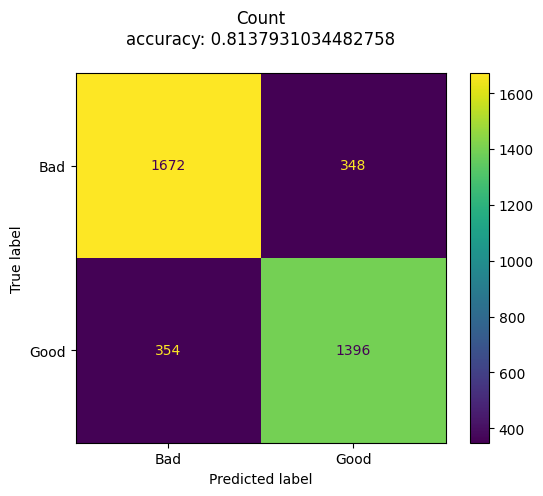

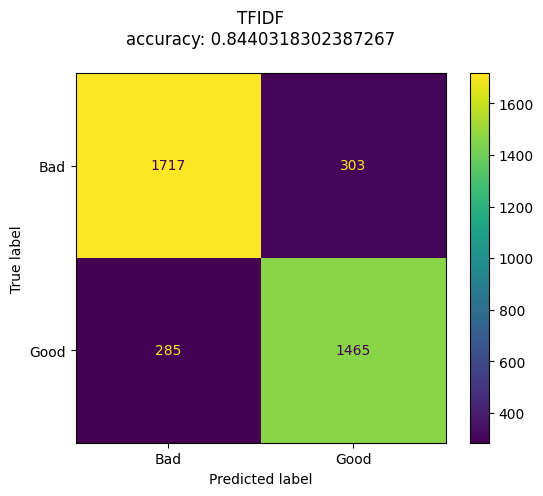

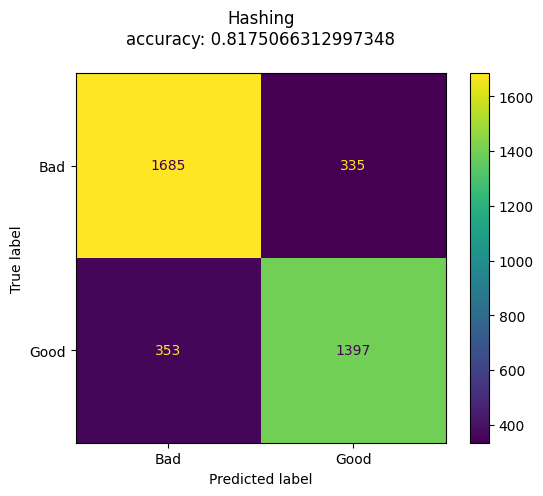

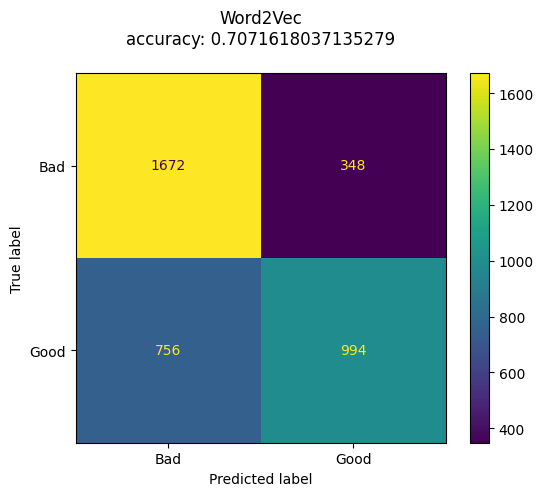

In [21]:
report = TestSVM(game_spot_svm_Count, game_spot_vectorizer_Count, game_spot_X_test, game_spot_y_test,"Count")
report = TestSVM(game_spot_svm_TFID, game_spot_vectorizer_TFID, game_spot_X_test, game_spot_y_test,"TFIDF")
report = TestSVM(game_spot_svm_Hashing, game_spot_vectorizer_Hashing, game_spot_X_test, game_spot_y_test,"Hashing")
report = TestSVM(game_spot_svm_W2V, game_spot_vectorizer_W2V, game_spot_X_test, game_spot_y_test,"Word2Vec")

### Test game_spot_svm on steam data

Testing SVM ...
Tested SVM in 6.806713581085205 s
accuracy: 0.5720407515848706

Testing SVM ...
Tested SVM in 8.679126739501953 s
accuracy: 0.28371132733882165

Testing SVM ...
Tested SVM in 6.2234930992126465 s
accuracy: 0.2630443035670638

Testing SVM ...
Tested SVM in 40.53668999671936 s
accuracy: 0.7294252861607909



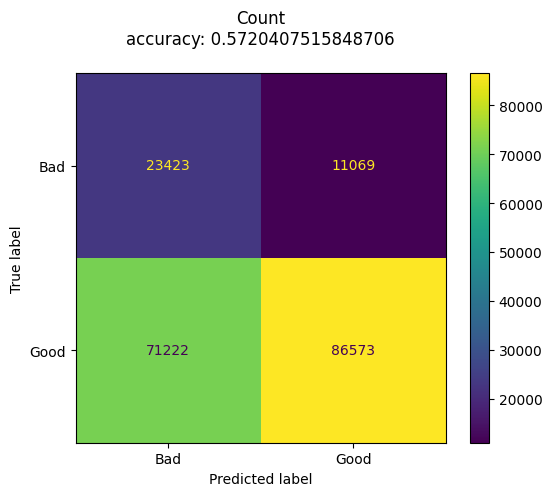

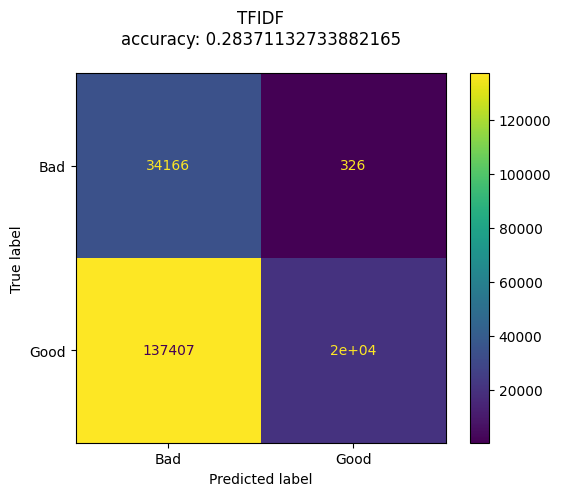

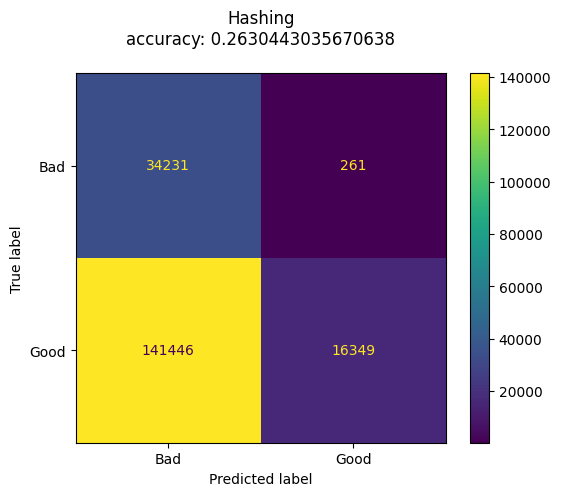

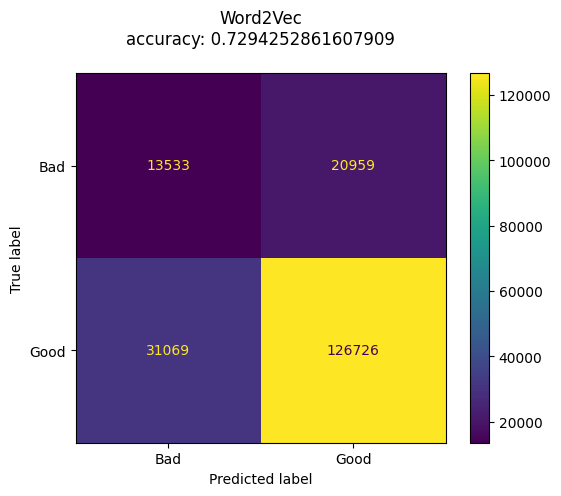

In [22]:
report = TestSVM(game_spot_svm_Count, game_spot_vectorizer_Count, steam_X_test, steam_y_test,"Count")
report = TestSVM(game_spot_svm_TFID, game_spot_vectorizer_TFID, steam_X_test, steam_y_test,"TFIDF")
report = TestSVM(game_spot_svm_Hashing, game_spot_vectorizer_Hashing, steam_X_test, steam_y_test,"Hashing")
report = TestSVM(game_spot_svm_W2V, game_spot_vectorizer_W2V, steam_X_test, steam_y_test,"Word2Vec")


### Test game_spot_svm on elden ring data

Testing SVM ...
Tested SVM in 0.05865597724914551 s
accuracy: 0.3744027303754266

Testing SVM ...
Tested SVM in 0.0711672306060791 s
accuracy: 0.15802047781569967

Testing SVM ...
Tested SVM in 0.05315446853637695 s
accuracy: 0.11501706484641638

Testing SVM ...
Tested SVM in 0.29597949981689453 s
accuracy: 0.8757679180887372



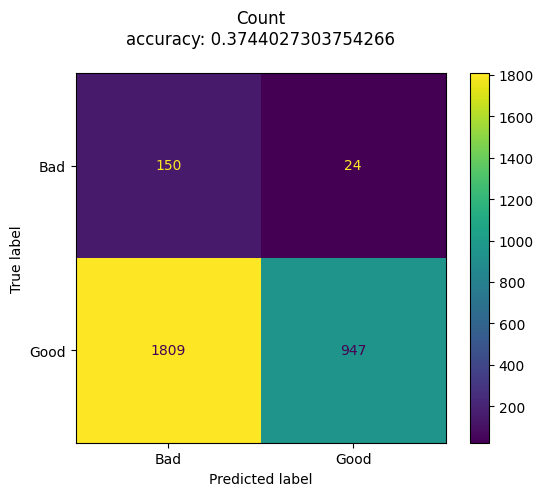

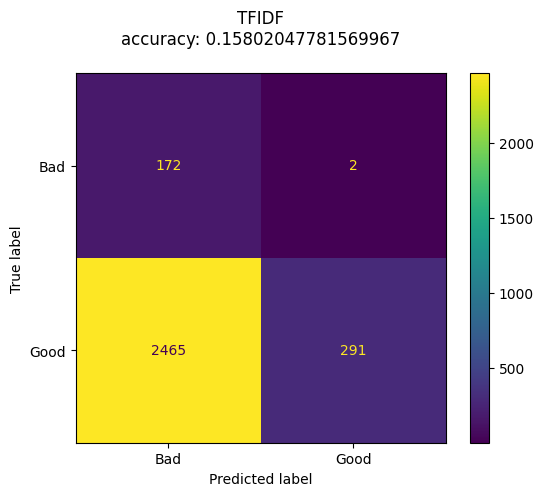

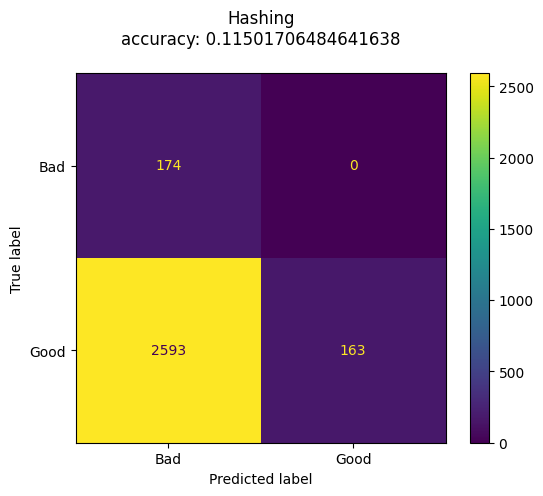

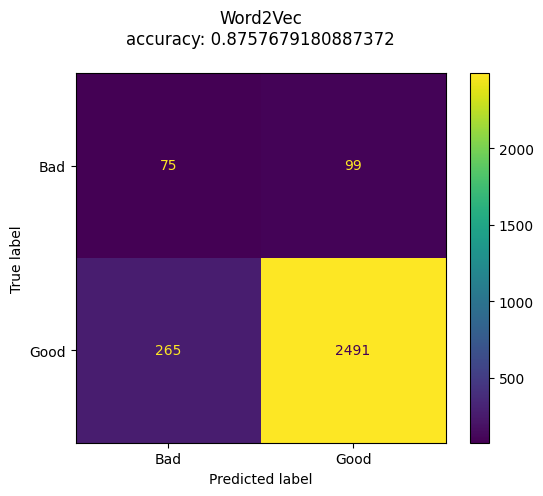

In [23]:
report = TestSVM(game_spot_svm_Count, game_spot_vectorizer_Count, elden_ring_X_test, elden_ring_y_test,"Count")
report = TestSVM(game_spot_svm_TFID, game_spot_vectorizer_TFID, elden_ring_X_test, elden_ring_y_test,"TFIDF")
report = TestSVM(game_spot_svm_Hashing, game_spot_vectorizer_Hashing, elden_ring_X_test, elden_ring_y_test,"Hashing")
report = TestSVM(game_spot_svm_W2V, game_spot_vectorizer_W2V, elden_ring_X_test, elden_ring_y_test,"Word2Vec")

# Train SVM with elden ring data

In [24]:
elden_ring_svm_Count, elden_ring_vectorizer_Count = CreateSVMCount(elden_ring_X_train, elden_ring_y_train)
elden_ring_svm_TFID, elden_ring_vectorizer_TFID = CreateSVMTFID(elden_ring_X_train, elden_ring_y_train)
elden_ring_svm_Hashing, elden_ring_vectorizer_Hashing = CreateSVMHashing(elden_ring_X_train, elden_ring_y_train)
elden_ring_svm_W2V, elden_ring_vectorizer_W2V = CreateSVMWord2Vec(elden_ring_X_train, elden_ring_y_train)

training SVM...
Trained SVM in 0.28209996223449707 s
training SVM...


C:\Programming\Anaconda\envs\CS_4630_Project\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Trained SVM in 0.15364289283752441 s
training SVM...
Trained SVM in 0.14587068557739258 s
training SVM...
fitting W2V transform...
Tokenizing...
done Tokenizing
building vocab...
done building vocab.
training W2V vectorizor...
done training W2V vectorizor.
done fitting W2V transform.
Trained SVM in 7.169301509857178 s


C:\Programming\Anaconda\envs\CS_4630_Project\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


### Test elden_ring_svm on elden ring test data

Testing SVM ...
Tested SVM in 0.06363916397094727 s
accuracy: 0.9436860068259386

Testing SVM ...
Tested SVM in 0.05712461471557617 s
accuracy: 0.952901023890785

Testing SVM ...
Tested SVM in 0.050005197525024414 s
accuracy: 0.9508532423208191

Testing SVM ...
Tested SVM in 0.2822694778442383 s
accuracy: 0.9385665529010239



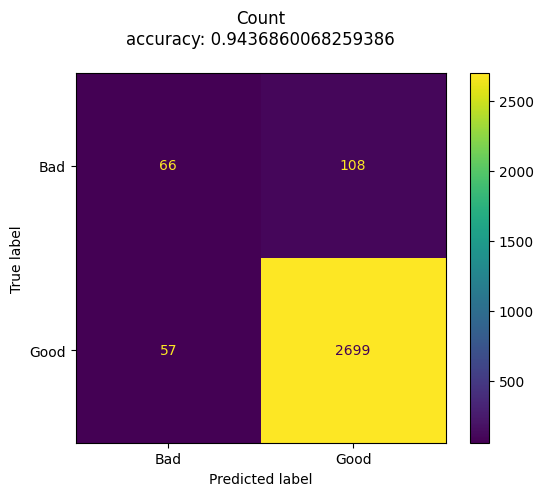

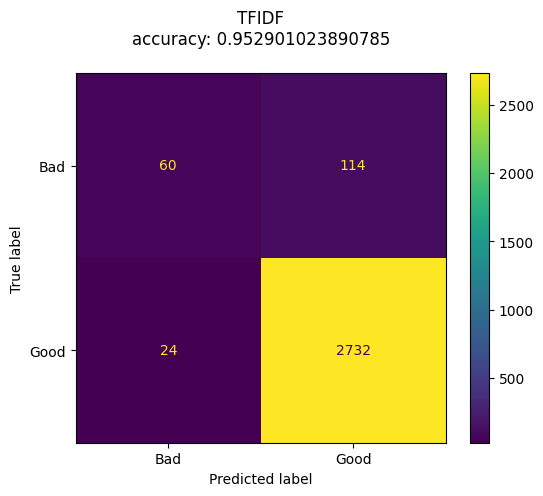

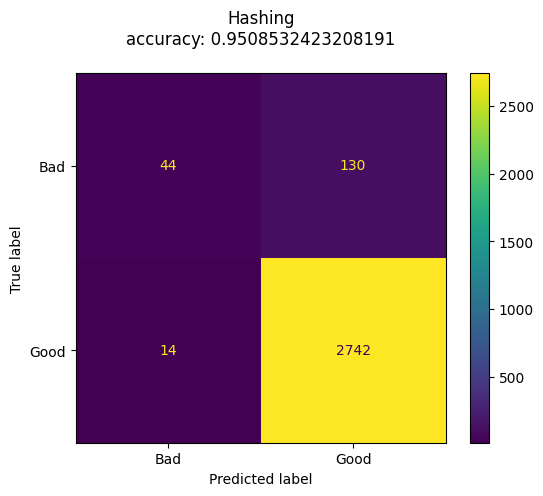

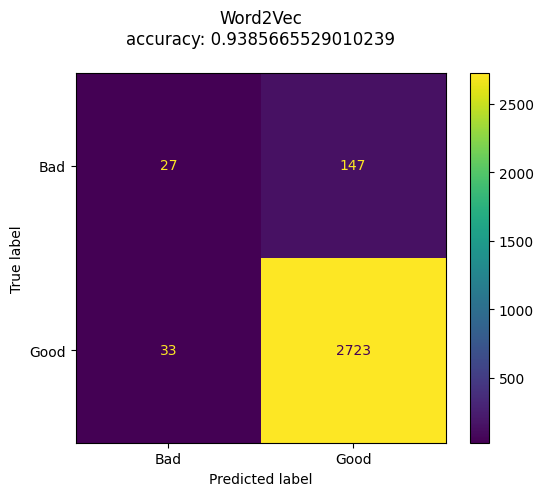

In [25]:
report = TestSVM(elden_ring_svm_Count, elden_ring_vectorizer_Count, elden_ring_X_test, elden_ring_y_test,"Count")
report = TestSVM(elden_ring_svm_TFID, elden_ring_vectorizer_TFID, elden_ring_X_test, elden_ring_y_test,"TFIDF")
report = TestSVM(elden_ring_svm_Hashing, elden_ring_vectorizer_Hashing, elden_ring_X_test, elden_ring_y_test,"Hashing")
report = TestSVM(elden_ring_svm_W2V, elden_ring_vectorizer_W2V, elden_ring_X_test, elden_ring_y_test,"Word2Vec")

### Test elden_ring_svm on steam data

Testing SVM ...
Tested SVM in 6.701662302017212 s
accuracy: 0.8275026392839869

Testing SVM ...
Tested SVM in 7.265427350997925 s
accuracy: 0.8402440102555034

Testing SVM ...
Tested SVM in 6.193135023117065 s
accuracy: 0.8352150691414396

Testing SVM ...
Tested SVM in 37.775506019592285 s
accuracy: 0.8106684279228445



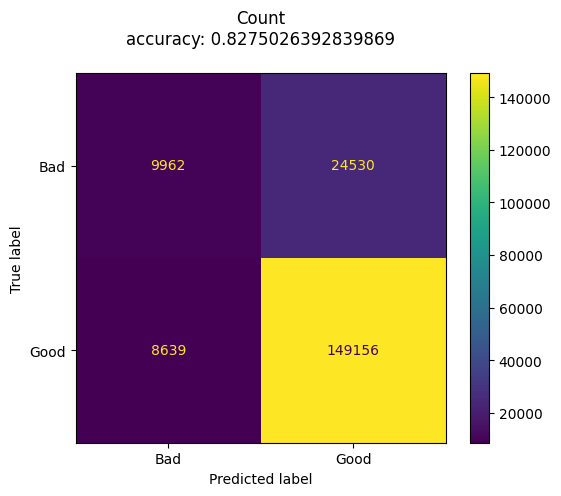

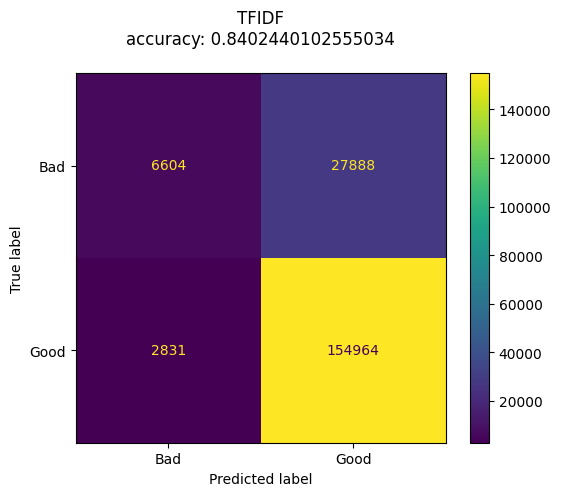

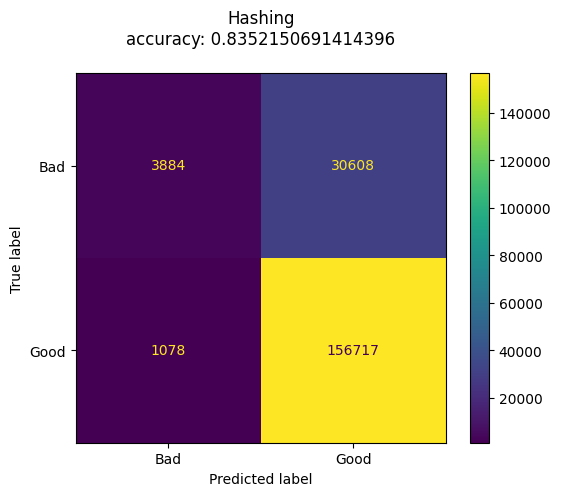

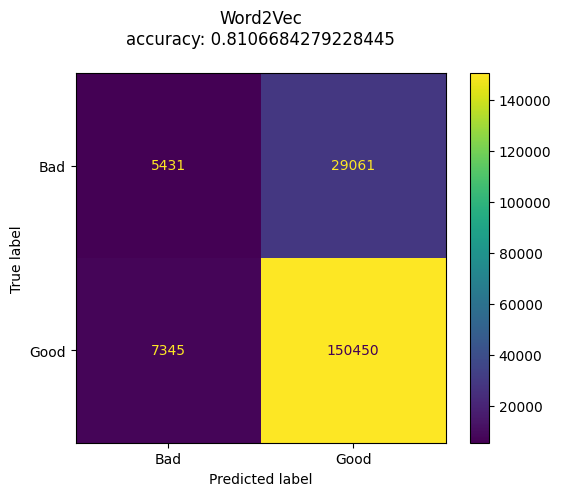

In [26]:
report = TestSVM(elden_ring_svm_Count, elden_ring_vectorizer_Count, steam_X_test, steam_y_test,"Count")
report = TestSVM(elden_ring_svm_TFID, elden_ring_vectorizer_TFID, steam_X_test, steam_y_test,"TFIDF")
report = TestSVM(elden_ring_svm_Hashing, elden_ring_vectorizer_Hashing, steam_X_test, steam_y_test,"Hashing")
report = TestSVM(elden_ring_svm_W2V, elden_ring_vectorizer_W2V, steam_X_test, steam_y_test,"Word2Vec")

### Test elden_ring_svm on game spot data

Testing SVM ...
Tested SVM in 2.7894949913024902 s
accuracy: 0.5607427055702918

Testing SVM ...
Tested SVM in 3.0514514446258545 s
accuracy: 0.5872679045092838

Testing SVM ...
Tested SVM in 2.737168550491333 s
accuracy: 0.4713527851458886

Testing SVM ...
Tested SVM in 15.925794124603271 s
accuracy: 0.5403183023872679



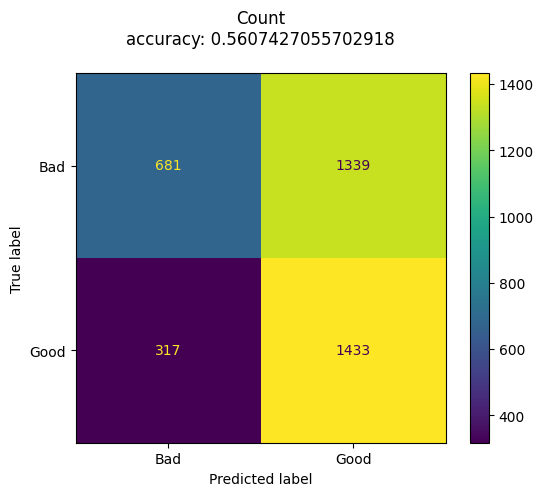

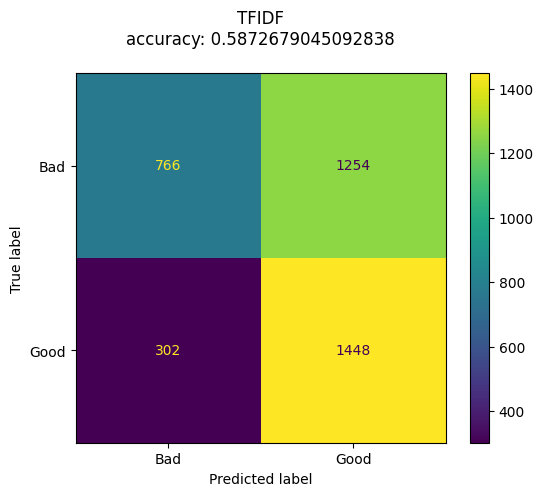

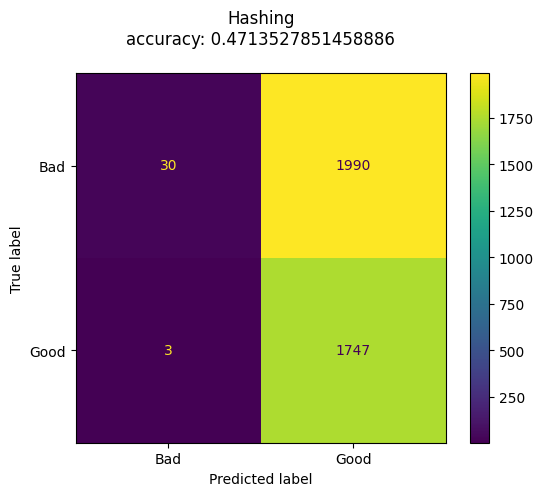

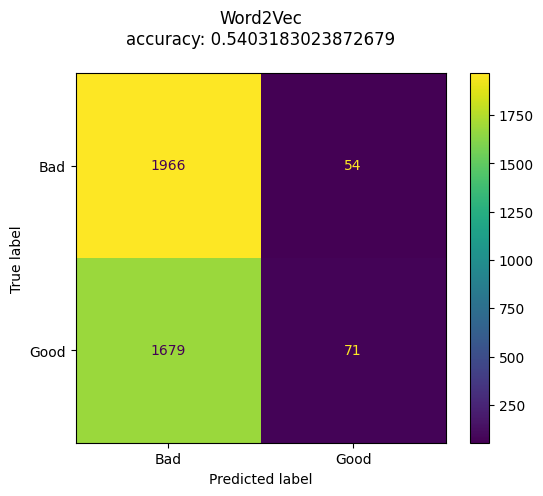

In [27]:
report = TestSVM(elden_ring_svm_Count, elden_ring_vectorizer_Count, game_spot_X_test, game_spot_y_test,"Count")
report = TestSVM(elden_ring_svm_TFID, elden_ring_vectorizer_TFID, game_spot_X_test, game_spot_y_test,"TFIDF")
report = TestSVM(elden_ring_svm_Hashing, elden_ring_vectorizer_Hashing, game_spot_X_test, game_spot_y_test,"Hashing")
report = TestSVM(elden_ring_svm_W2V, elden_ring_vectorizer_W2V, game_spot_X_test, game_spot_y_test,"Word2Vec")

# Train SVM with Steam Data

In [28]:
steam_svm_Count, steam_vectorizer_Count = CreateSVMCount(steam_X_train, steam_y_train)
steam_svm_TFID, steam_vectorizer_TFID = CreateSVMTFID(steam_X_train, steam_y_train)
steam_svm_Hashing, steam_vectorizer_Hashing = CreateSVMHashing(steam_X_train, steam_y_train)
steam_svm_W2V, steam_vectorizer_W2V = CreateSVMWord2Vec(steam_X_train, steam_y_train)

training SVM...


C:\Programming\Anaconda\envs\CS_4630_Project\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Trained SVM in 163.06532073020935 s
training SVM...
Trained SVM in 23.72340488433838 s
training SVM...
Trained SVM in 23.08392858505249 s
training SVM...
fitting W2V transform...
Tokenizing...
done Tokenizing
building vocab...
done building vocab.
training W2V vectorizor...
done training W2V vectorizor.
done fitting W2V transform.


C:\Programming\Anaconda\envs\CS_4630_Project\Lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Trained SVM in 742.413964509964 s


### Test steam_svm on steam data

Testing SVM ...
Tested SVM in 7.3079633712768555 s
accuracy: 0.8747497230702024

Testing SVM ...
Tested SVM in 7.376726388931274 s
accuracy: 0.885421271328795

Testing SVM ...
Tested SVM in 6.302049875259399 s
accuracy: 0.8852808562201293

Testing SVM ...
Tested SVM in 41.1825909614563 s
accuracy: 0.8499950594683988



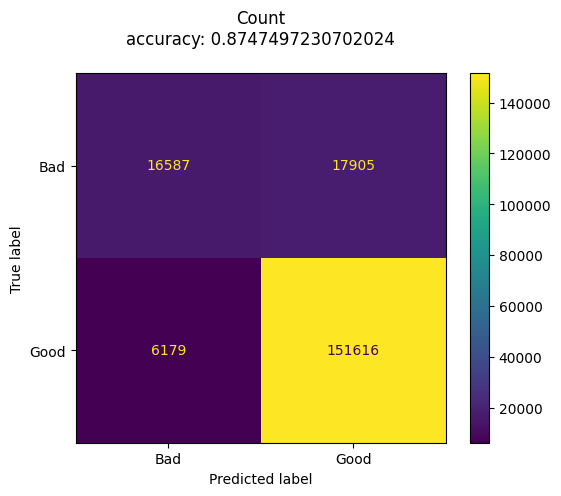

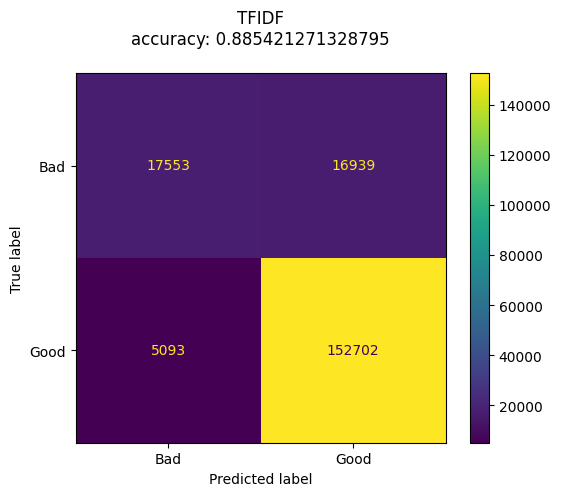

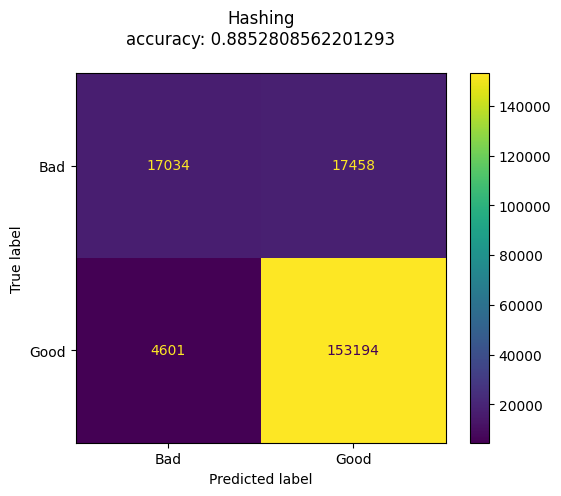

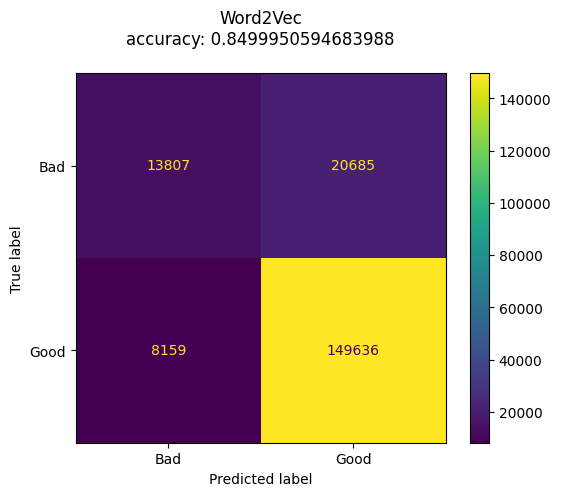

In [29]:
report = TestSVM(steam_svm_Count, steam_vectorizer_Count, steam_X_test, steam_y_test,"Count")
report = TestSVM(steam_svm_TFID, steam_vectorizer_TFID, steam_X_test, steam_y_test,"TFIDF")
report = TestSVM(steam_svm_Hashing, steam_vectorizer_Hashing, steam_X_test, steam_y_test,"Hashing")
report = TestSVM(steam_svm_W2V, steam_vectorizer_W2V, steam_X_test, steam_y_test,"Word2Vec")

### Test steam_svm on game spot data

Testing SVM ...
Tested SVM in 2.8509485721588135 s
accuracy: 0.5830238726790451

Testing SVM ...
Tested SVM in 2.8581089973449707 s
accuracy: 0.6

Testing SVM ...
Tested SVM in 2.699328899383545 s
accuracy: 0.5169761273209549

Testing SVM ...
Tested SVM in 18.225054025650024 s
accuracy: 0.47214854111405835



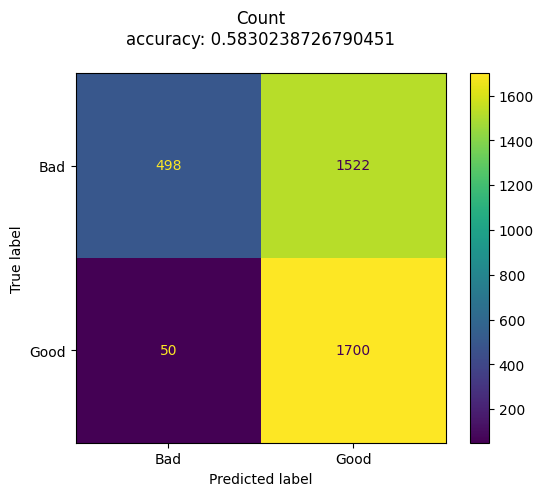

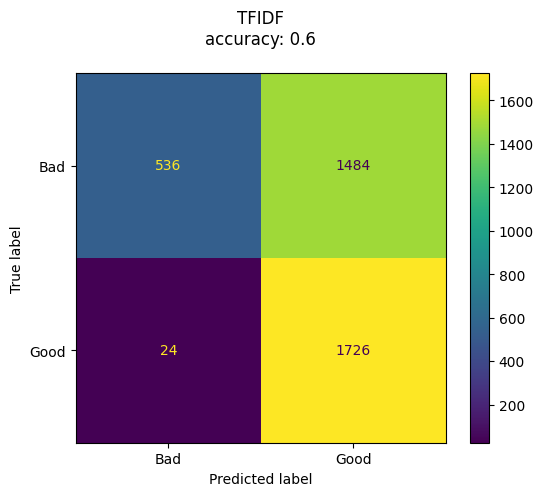

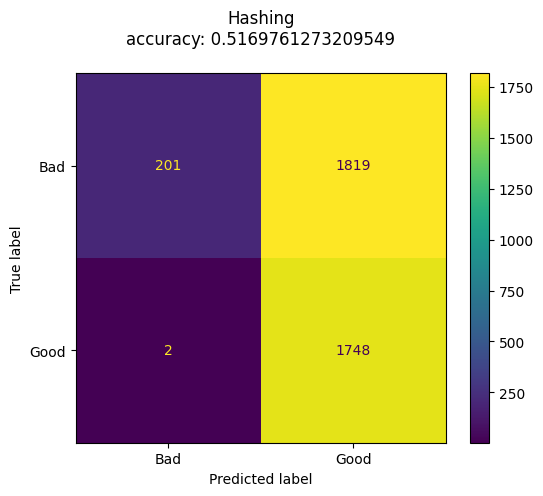

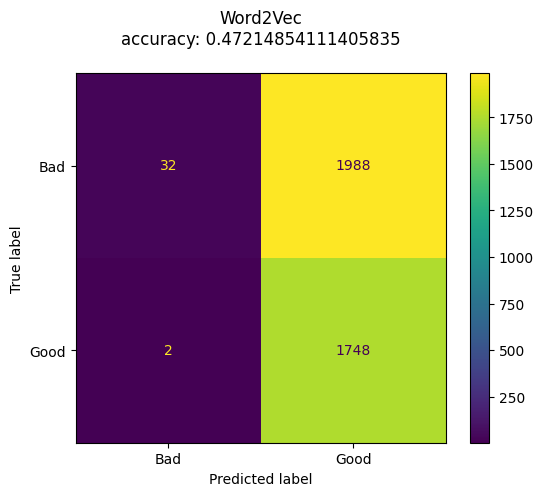

In [30]:
report = TestSVM(steam_svm_Count, steam_vectorizer_Count, game_spot_X_test, game_spot_y_test,"Count")
report = TestSVM(steam_svm_TFID, steam_vectorizer_TFID, game_spot_X_test, game_spot_y_test,"TFIDF")
report = TestSVM(steam_svm_Hashing, steam_vectorizer_Hashing, game_spot_X_test, game_spot_y_test,"Hashing")
report = TestSVM(steam_svm_W2V, steam_vectorizer_W2V, game_spot_X_test, game_spot_y_test,"Word2Vec")

### Test steam_svm on elden ring data

Testing SVM ...
Tested SVM in 0.06105613708496094 s
accuracy: 0.9457337883959044

Testing SVM ...
Tested SVM in 0.06105661392211914 s
accuracy: 0.9440273037542662

Testing SVM ...
Tested SVM in 0.051551103591918945 s
accuracy: 0.9477815699658703

Testing SVM ...
Tested SVM in 0.2983074188232422 s
accuracy: 0.9389078498293515



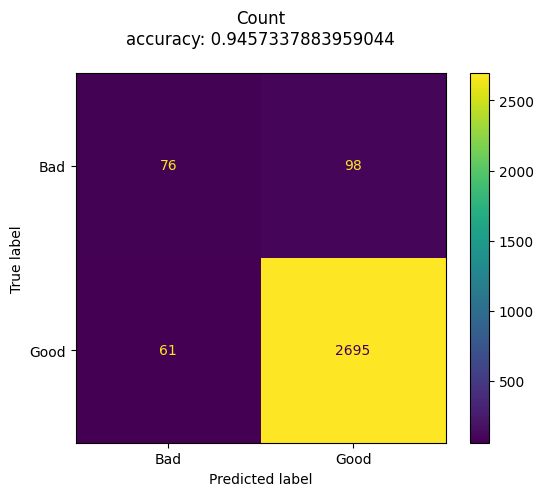

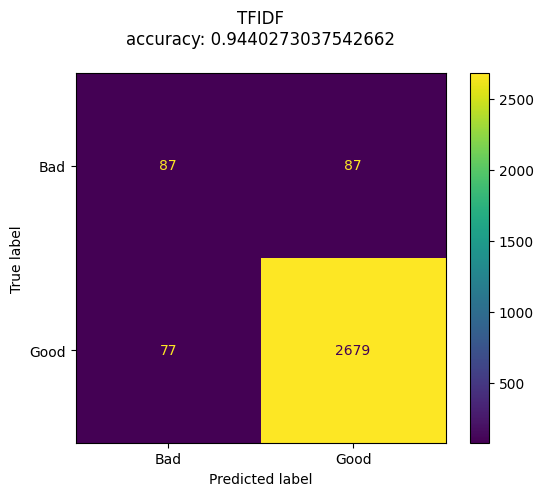

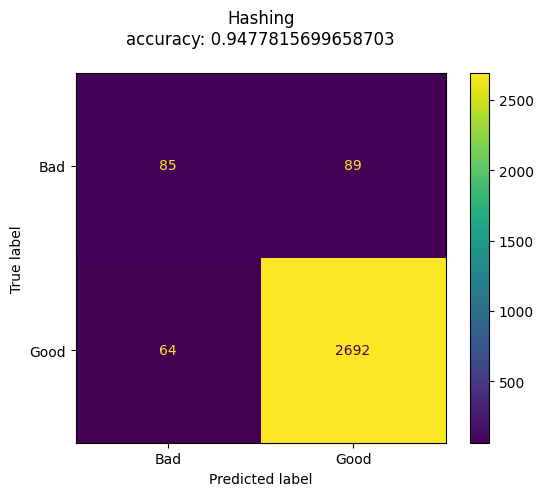

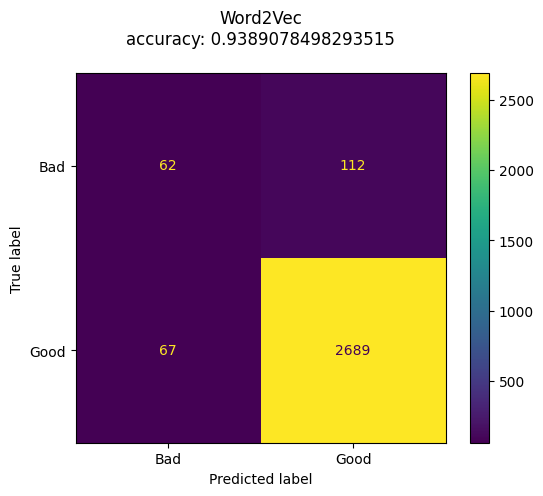

In [31]:
report = TestSVM(steam_svm_Count, steam_vectorizer_Count, elden_ring_X_test, elden_ring_y_test,"Count")
report = TestSVM(steam_svm_TFID, steam_vectorizer_TFID, elden_ring_X_test, elden_ring_y_test,"TFIDF")
report = TestSVM(steam_svm_Hashing, steam_vectorizer_Hashing, elden_ring_X_test, elden_ring_y_test,"Hashing")
report = TestSVM(steam_svm_W2V, steam_vectorizer_W2V, elden_ring_X_test, elden_ring_y_test,"Word2Vec")

In [32]:
print("WAKE ME UP!")

WAKE ME UP!
